# Web Scraping for Indeed.com & Predicting Salaries

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary classifier.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being to able extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use a random forest regressor, as well as another classifier of your choice; either logistic regression, SVM, or KNN. 

- **Question**: Why would we want this to be a classification problem?
- **Answer**: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range be may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10")

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

## Import Libraries

In [ ]:
import requests
from bs4 import BeautifulSoup

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element="jobTitle`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### Write 4 functions to extract each item: location, company, job, and salary.

example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it
    - Remember to use `try/except` if you anticipate errors
- **Test** the functions on the results above and simple examples

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different

## Import Data

In [ ]:
max_results_per_city = 4000 

results = []

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', 'Washington+City%2C+DC']):
    for start in range(0, max_results_per_city, 10):
        r = requests.get('http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=' + city + '&jt=fulltime&explvl=entry_level&start=' + str(start))
        b = BeautifulSoup(r.text)
        results.append(b.find_all("div", class_ = "result"))
        

In [ ]:
# Data in results is a list of lists. To make processing easier, I flatten to an unnested list.
results = [item for sublist in results for item in sublist]

## Extraction 

In [ ]:
# Crafting the hefty "results" a dictionary ("extracted") of desired elements (job title, company, salary, location,
# and a short job summary).

extracted = {}

def extraction(results):
    titles = []
    companies = []
    salaries = []
    locations = []
    summaries = []
    for result in results:
        
        # job title
        titles.append(result.find('a',{'data-tn-element':'jobTitle'}).text)
        
        # company
        try:
            companies.append(result.find("span",{'class':'company'}).get_text(strip=True))
        except AttributeError:
            companies.append(None)
            
        # salary    
        try:
            salaries.append(result.find(name='nobr').text)
        except AttributeError:
            salaries.append(None)
     
        # location
        locations.append(result.find("span", class_ = "location").text)
        
        # summary
        summaries.append(result.find("span", class_ = "summary").get_text(strip=True))
        
    extracted['titles'] = titles
    extracted['companies'] = companies
    extracted['salaries'] = salaries
    extracted['locations'] = locations
    extracted['summaries'] = summaries

In [1]:
import pandas as pd

In [ ]:
listings = pd.DataFrame.from_dict(extracted)

In [ ]:
# Since I'm working with a big file that takes > an hour to scrape, I save it as a csv on my desktop. This way if this
# notebook ever crashes I won't have to go through the process of rescraping. 
listings.to_csv('/users/nick/desktop/indeed_jobs.csv', encoding='utf-8')

In [2]:
listings = pd.read_csv('/users/nick/desktop/indeed_jobs.csv')

In [3]:
listings.head()

,Unnamed: 0,companies,locations,salaries,summaries,titles
0,0,Philips Lighting,United States,NaN,DataScientist/ Machine LearningScientist. Expe...,Data Scientist / Machine Learning Scientist
1,1,Amazon Corporate LLC,United States,NaN,"As a Principal, you will provide leadership to...",Principal Data Scientist - Consumer Website- R...
2,2,alliantgroup,"Houston, TX",NaN,Assist in the research & analysis of clientdat...,Engineering Consultant
3,3,Baylor Miraca Genetics Laboratories LLC,"Houston, TX",NaN,Utilizes established scientific techniques toc...,Research & Development Scientist III
4,4,Rice University,"Houston, TX",NaN,Faculty inDataScience. (1)datascientistswho ca...,Faculty in Data Science


In [4]:
# I pulled over 90,000 job postings from Indeed!
listings.shape

(90724, 6)

In [5]:
listings.drop('Unnamed: 0', axis=1, inplace=True)

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [6]:
# Unfortunately, most of the job postings did not include salary information. Since these rows won't be any good for 
# model-building, I'll drop them.
listings[listings.salaries.isnull()].shape

(87040, 5)

In [7]:
listings.dropna(subset=['salaries'], how='all', inplace = True)

In [8]:
# Getting rid of non-annual (hourly, weekly, monthly) salaries.
listings = listings[~listings.salaries.str.contains('month') & ~listings.salaries.str.contains('week') & ~listings.salaries.str.contains('hour')]

In [9]:
# Another issue to be wary of: a single job that was posted multiple times. I want these dropped.
listings.duplicated().sum()

753

In [10]:
listings.loc[listings.duplicated(keep=False), :]

,companies,locations,salaries,summaries,titles
23754,Pro Partners Staffing,"New York, NY","$80,000 a year",Collect returns and exposuredatafor performanc...,Research/Marketing Analyst
23760,Pro Partners Staffing,"New York, NY","$80,000 a year",Collect returns and exposuredatafor performanc...,Research/Marketing Analyst
23925,Selby Jennings,"New York, NY 10167 (Midtown area)","$110,000 - $190,000 a year",A Tier One Investment Bank is seeking a Quanti...,Quantitative Analyst for Counterparty Risk Tea...
23940,Selby Jennings,"New York, NY 10167 (Midtown area)","$110,000 - $190,000 a year",A Tier One Investment Bank is seeking a Quanti...,Quantitative Analyst for Counterparty Risk Tea...
23955,Selby Jennings,"New York, NY 10167 (Midtown area)","$110,000 - $190,000 a year",A Tier One Investment Bank is seeking a Quanti...,Quantitative Analyst for Counterparty Risk Tea...
23970,Selby Jennings,"New York, NY 10167 (Midtown area)","$110,000 - $190,000 a year",A Tier One Investment Bank is seeking a Quanti...,Quantitative Analyst for Counterparty Risk Tea...
23985,Selby Jennings,"New York, NY 10167 (Midtown area)","$110,000 - $190,000 a year",A Tier One Investment Bank is seeking a Quanti...,Quantitative Analyst for Counterparty Risk Tea...
24000,Selby Jennings,"New York, NY 10167 (Midtown area)","$110,000 - $190,000 a year",A Tier One Investment Bank is seeking a Quanti...,Quantitative Analyst for Counterparty Risk Tea...
24015,Selby Jennings,"New York, NY 10167 (Midtown area)","$110,000 - $190,000 a year",A Tier One Investment Bank is seeking a Quanti...,Quantitative Analyst for Counterparty Risk Tea...
24030,Selby Jennings,"New York, NY 10167 (Midtown area)","$110,000 - $190,000 a year",A Tier One Investment Bank is seeking a Quanti...,Quantitative Analyst for Counterparty Risk Tea...


In [11]:
listings.drop_duplicates(inplace=True)

In [12]:
# This will speed up iterating through my dataframe. Necessary for the "for i, e in enumerate()" tactic (below).
listings.reset_index(drop=True, inplace=True)

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now
1. Some of the entries may be duplicated
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries

In [13]:
# Getting rid of commas and $s in the salaries column.
listings.salaries = listings.salaries.apply(lambda x: x.replace(',',''))

In [14]:
listings.salaries = listings.salaries.apply(lambda x: x.replace('$',''))

In [15]:
import re

In [16]:
# Creating a list separate from my dataframe only to insert it into my dataframe may be an unnecessary step,
# (instead of making a list, why not make a new column -- or better, overwrite the source column?), but it's 
# easy enough and I know how to do it.
salaries = []
for salary in listings.salaries:
    salaries.append(re.findall(r'\d+', salary))

In [17]:
listings['salary'] = salaries

In [18]:
# Checking data type of entries in 'salary' column. If I don't include the inside for loop, the type of each 
# cell would be 'list.' 
for i, e in enumerate(listings.salary):
    for a, b in enumerate(listings.salary[i]):
        print type(listings.salary[i][a])

<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>
<type 'str'>

In [19]:
# To calculate median salary, I'll need to convert "str" to "int."
for i,e in enumerate(listings.salary):
    for a,b in enumerate(listings.salary[i]):
        listings.salary[i][a] = int(b)

In [20]:
# Every value, whether a pair of values or a single value, is within a list. But by performing an operation on the 
# values inside the list a single (non-list) value is returned. 
for i,e in enumerate(listings.salary):
    if len(e) > 1:
        listings.salary[i] = sum(e)/2.
    else:
        listings.salary[i] = sum(e)

In [ ]:
listings.head()

In [21]:
# 'salaries', which is provides the text from which 'salary' was derived, won't be used in modeling and can be dropped.
listings.drop('salaries', axis=1, inplace=True)

In [22]:
# Since the format is "City, STATE", this returns city. 
listings['city'] = listings.locations.apply(lambda x: x.split(',')[0])

In [ ]:
listings.head()

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median)

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choice the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries, 

In [23]:
# Set a default value for whether or not a given job's salary is above the median.
listings['above_median'] = 0

In [24]:
for i, e in enumerate(listings.above_median):
    if listings.salary[i] > listings.salary.median():
        listings.above_median[i] = 1
    else:
        listings.above_median[i] = 0

/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [26]:
listings.above_median.value_counts()

0    62
1    61
Name: above_median, dtype: int64

## Predicting salaries using Random Forests + Another Classifier

## Random Forest - Get Dummies

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold, KFold

In [40]:
X = listings.city
y = listings.above_median

In [45]:
X.value_counts(ascending=False).head()

New York      39
Atlanta        9
Washington     9
Chicago        8
Newark         6
Name: city, dtype: int64

In [46]:
X = pd.get_dummies(X)
X.drop('New York', axis=1, inplace=True)

In [63]:
cv = KFold(len(y), n_folds=3, shuffle=True, random_state=41)
rfc = RandomForestClassifier()
cross_val_score(rfc, X, y, cv = cv).mean()

0.61788617886178865

In [64]:
from sklearn.grid_search import GridSearchCV

param_grid = {'n_estimators':[8,10,12,20],
              'criterion': ['gini', 'entropy'],
              'max_features':['sqrt', 'log2', None],
              'min_samples_split':[2,4,6,8],
              'min_samples_leaf': [1,2,3,4]}

gs = GridSearchCV(rfc, param_grid, cv=cv)

In [65]:
gs.fit(X, y)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=123, n_folds=3, shuffle=True, random_state=41),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [8, 10, 12, 20], 'max_features': ['sqrt', 'log2', None], 'min_samples_split': [2, 4, 6, 8], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [66]:
print gs.best_score_
print gs.best_params_

0.642276422764
{'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 20, 'criterion': 'gini', 'min_samples_leaf': 1}


## Random Forest - LabelEncoder

In [142]:
# I'm using labelencoder mainly so that I can plot. (Plotting not viable when city is split over 30+ variables.) 
# But it also makes a leaner dataframe, and since I'm using randomforest, it should have no (significant) impact 
# on outcome.
X = listings.city
y = listings.above_median

from sklearn.preprocessing import LabelEncoder
X = pd.DataFrame(LabelEncoder().fit_transform(X))

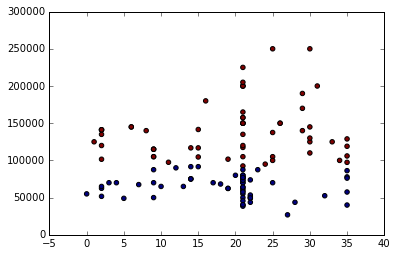

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X, listings.salary, c=y)

In [144]:
cv = KFold(len(y), n_folds=3, shuffle=True, random_state=41)
rfc = RandomForestClassifier()
cross_val_score(rfc, X, y, cv = cv).mean()

0.57723577235772361

In [145]:
param_grid = {'n_estimators':[8,10,12,20],
              'criterion': ['gini', 'entropy'],
              'max_features':['sqrt', 'log2', None],
              'min_samples_split':[2,4,6,8],
              'min_samples_leaf': [1,2,3,4]}

gs = GridSearchCV(rfc, param_grid, cv=cv)

In [146]:
gs.fit(X, y)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=123, n_folds=3, shuffle=True, random_state=41),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [8, 10, 12, 20], 'max_features': ['sqrt', 'log2', None], 'min_samples_split': [2, 4, 6, 8], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [147]:
print gs.best_score_
print gs.best_params_

0.650406504065
{'max_features': None, 'min_samples_split': 4, 'n_estimators': 8, 'criterion': 'gini', 'min_samples_leaf': 2}


## Logistic Regression

In [ ]:
# I have too many classes, with too few observations, to run a logistic regression. That's okay. It would've 
# been a pretty hokey solution anyway.

#### Create a few new variables in your dataframe to represent interesting features of a job title.
- For example, create a feature that represents whether 'Senior' is in the title 
- or whether 'Manager' is in the title. 
- Then build a new Random Forest with these features. Do they add any value? 


In [67]:
listings.titles

0                     Bioinformatics Postdoctoral Fellow
1                                         Data Architect
2                                 Data Services Engineer
3                          Web Security Research Analyst
4                                         Data Scientist
5                                         Data Scientist
6                                     Software Scientist
7                        Data Scientist- Python/Big Data
8                                       Research Analyst
9      Market Research Analyst - (Quantitative Resear...
10                              Mid-Level Data Scientist
11                 Lead Data Scientist (Graph Analytics)
12                    Save lives via experimental design
13                     Data Scientist (Machine Learning)
14          Data Scientist / Bioinformatics (co-founder)
15            Systemwide Library Research Analyst (7399)
16                                        Data Scientist
17          Data Scientist (Nat

In [68]:
# Create two columns. One for jobs with senior keywords, the other for jobs with junior keywords. Set default to 0.
listings['senior'] = 0
listings['entry'] = 0

In [70]:
for i, e in enumerate(listings.senior):
    if 'Lead' in listings.titles[i]:
        listings.senior[i] = 1
    elif 'Senior' in listings.titles[i]:
        listings.senior[i] = 1
    elif 'Manager' in listings.titles[i]:
        listings.senior[i] = 1
    elif 'Experienced' in listings.titles[i]:
        listings.senior[i] = 1
    else:
        listings.senior[i] = 0

/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value 

In [71]:
for i, e in enumerate(listings.entry):
    if 'Junior' in listings.titles[i]:
        listings.entry[i] = 1
    elif 'Entry' in listings.titles[i]:
        listings.entry[i] = 1
    else:
        listings.entry[i] = 0

/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Nick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [73]:
# Not many job titles that could be obviously identified as junior or senior.
print listings.senior.sum()
print listings.entry.sum()

12
4


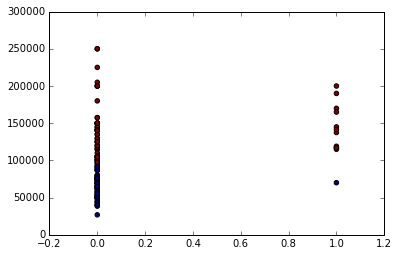

In [152]:
plt.scatter(listings.senior, listings.salary, c=y)

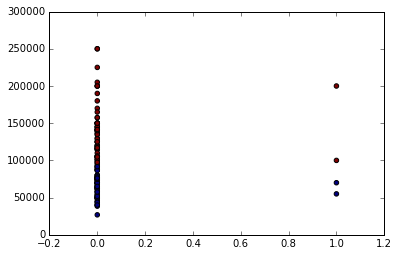

In [153]:
plt.scatter(listings.entry, listings.salary, c=y)

In [82]:
X = listings.city
X = pd.get_dummies(X)
X.drop('New York', axis=1, inplace=True)
X['senior'] = listings.senior
X['entry'] = listings.entry

In [83]:
X.head()

,Annapolis Junction,Arlington,Atlanta,Austin,Bellevue,Berkeley,Brisbane,Brooklyn,Chantilly,Chicago,...,Portland,Redwood City,San Francisco,Santa Monica,Scottsdale,Seattle,Walnut Creek,Washington,senior,entry
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [99]:
cv = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=41)
rfc = RandomForestClassifier(n_estimators = 20)
cross_val_score(rfc, X, y, cv = cv).mean()

0.61869230769230765

In [90]:
gs = GridSearchCV(rfc, param_grid, cv=cv)
gs.fit(X, y)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 1 ..., 0 1], n_folds=5, shuffle=True, random_state=41),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [8, 10, 12, 20], 'max_features': ['sqrt', 'log2', None], 'min_samples_split': [2, 4, 6, 8], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [91]:
print gs.best_score_
print gs.best_params_

0.658536585366
{'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 12, 'criterion': 'gini', 'min_samples_leaf': 1}


# Support Vector Machines

In [251]:
from sklearn import svm

In [255]:
X.head()

,Annapolis Junction,Arlington,Atlanta,Austin,Bellevue,Berkeley,Brisbane,Brooklyn,Chantilly,Chicago,...,Portland,Redwood City,San Francisco,Santa Monica,Scottsdale,Seattle,Walnut Creek,Washington,senior,entry
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [253]:
# Laughably bad score!
svc = svm.SVC(kernel = 'linear')
cross_val_score(svc, X, y, scoring='accuracy').mean()

/Users/Nick/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


0.13247863247863248

In [254]:
# Even worse!! While gridsearching would make things better, this isn't a route worth pursuing.
# Measuring vectors in an entirely categorical space is misguided.
svc = svm.SVC(kernel = 'rbf')
cross_val_score(svc, X, y, scoring='accuracy').mean()

0.07521367521367521

## TF-IDF w/ Logistic Regression

In [211]:
X = listings.loc[:, ['titles', 'summaries']]
y = listings.above_median

In [212]:
X['alltext'] = X.titles + X.summaries

In [213]:
X.drop(['titles', 'summaries'], axis=1, inplace=True)

In [226]:
# I don't want to deal with a list of lists, so I use ravel.
X_train.values.ravel()

array([ 'Research Assistant/Analyst, Africa Growth InitiativeResearchesdatasources, updates and checks existing data; Experience handling, manipulating, and analyzing largedatasets....',
       'Save lives via experimental designRequirements for alldatascientists. Expert in Python and core libraries used bydatascientists(Numpy, Scipy, Pandas, Scikit-learn, Matplotlib/Seaborn, etc.)...',
       'Research Teaching Specialist VAssists interventions (educational and/or environmental), incident/injury surveillance and training evaluationdataentry and analysis....',
       'Supervisory StatisticianDemonstrated ability to establish goals and objectives, develop and implement programs and activities to collect and analyzedatarelated to vital recordsdata...',
       'Senior Data ScientistOrdatavisualization and interaction. The SeniorDataScientistin The Lab @ DC possesses expert skills in programming, statistics, and scientific...',
       'Staff Assistant (Confidential)Executes assignments and

In [178]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

In [215]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [227]:
tvec.fit(X_train.values.ravel(), y_train)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [206]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr = LogisticRegression()

In [228]:
X_train = pd.DataFrame(tvec.transform(X_train.values.ravel()).todense(),
                   columns=tvec.get_feature_names())
X_test = pd.DataFrame(tvec.transform(X_test.values.ravel()).todense(),
                   columns=tvec.get_feature_names())

In [229]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [231]:
y_pred = lr.predict(X_test)
metrics.accuracy_score(y_pred, y_test)

0.70967741935483875

## TF-IDF w/ SVM

In [257]:
X = listings.loc[:, ['titles', 'summaries']]
y = listings.above_median
X['alltext'] = X.titles + X.summaries
X.drop(['titles', 'summaries'], axis=1, inplace=True)
X_train.values.ravel()
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)
tvec.fit(X_train.values.ravel(), y_train)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [258]:
X_train = pd.DataFrame(tvec.transform(X_train.values.ravel()).todense(),
                   columns=tvec.get_feature_names())
X_test = pd.DataFrame(tvec.transform(X_test.values.ravel()).todense(),
                   columns=tvec.get_feature_names())

In [259]:
svc = svm.SVC()

In [261]:
import numpy as np

In [262]:
gamma_range = 10.**np.arange(-5, 2)
C_range = 10.**np.arange(-2, 3)
kernel_range = ['rbf', 'sigmoid', 'linear', 'poly']
param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel_range)
gs = GridSearchCV(svc, param_grid, cv=10, scoring='accuracy')
gs.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf', 'sigmoid', 'linear', 'poly'], 'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02]), 'gamma': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [264]:
print gs.best_score_
print gs.best_params_
print gs.best_estimator_

0.728260869565
{'kernel': 'rbf', 'C': 10.0, 'gamma': 0.10000000000000001}
SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.10000000000000001,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


## TF-IDF w/ Random Forest

In [275]:
X = listings.loc[:, ['titles', 'summaries']]
y = listings.above_median
X['alltext'] = X.titles + X.summaries
X.drop(['titles', 'summaries'], axis=1, inplace=True)
X_train.values.ravel()
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()
tvec.fit(X.values.ravel(), y)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [276]:
X = pd.DataFrame(tvec.transform(X.values.ravel()).todense(),
                   columns=tvec.get_feature_names())

In [277]:
cv = KFold(len(y), n_folds=3, shuffle=True, random_state=41)
rfc = RandomForestClassifier()
cross_val_score(rfc, X, y, cv = cv).mean()

0.65853658536585369

In [278]:
param_grid = {'n_estimators':[8,10,12,20],
              'criterion': ['gini', 'entropy'],
              'max_features':['sqrt', 'log2', None],
              'min_samples_split':[2,4,6,8],
              'min_samples_leaf': [1,2,3,4]}

gs = GridSearchCV(rfc, param_grid, cv=cv)

In [279]:
gs.fit(X, y)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=123, n_folds=3, shuffle=True, random_state=41),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [8, 10, 12, 20], 'max_features': ['sqrt', 'log2', None], 'min_samples_split': [2, 4, 6, 8], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [280]:
print gs.best_score_
print gs.best_params_
print gs.best_estimator_

0.772357723577
{'max_features': None, 'min_samples_split': 4, 'n_estimators': 12, 'criterion': 'entropy', 'min_samples_leaf': 3}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=3, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=12, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


## Same as above, but with city

In [281]:
X['city'] = listings.city

In [284]:
X.city = pd.DataFrame(LabelEncoder().fit_transform(X.city))

In [289]:
gs.fit(X, y)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=123, n_folds=3, shuffle=True, random_state=41),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [8, 10, 12, 20], 'max_features': ['sqrt', 'log2', None], 'min_samples_split': [2, 4, 6, 8], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [290]:
# Unfortunately, just a little bit worse.
print gs.best_score_
print gs.best_params_
print gs.best_estimator_

0.756097560976
{'max_features': None, 'min_samples_split': 2, 'n_estimators': 8, 'criterion': 'entropy', 'min_samples_leaf': 2}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


## Extra Trees Classifier

In [296]:
X = listings.loc[:, ['titles', 'summaries']]
y = listings.above_median
X['alltext'] = X.titles + X.summaries
X.drop(['titles', 'summaries'], axis=1, inplace=True)
X_train.values.ravel()
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()
tvec.fit(X.values.ravel(), y)

TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern=u'(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [297]:
X = pd.DataFrame(tvec.transform(X.values.ravel()).todense(),
                   columns=tvec.get_feature_names())

In [302]:
from sklearn.ensemble import ExtraTreesClassifier

In [303]:
cv = KFold(len(y), n_folds=3, shuffle=True, random_state=41)
etc = ExtraTreesClassifier()
cross_val_score(etc, X, y, cv = cv).mean()

0.73170731707317083

In [304]:
param_grid = {'n_estimators':[8,10,12,20],
              'criterion': ['gini', 'entropy'],
              'max_features':['sqrt', 'log2', None],
              'min_samples_split':[2,4,6,8],
              'min_samples_leaf': [1,2,3,4]}

gs = GridSearchCV(etc, param_grid, cv=cv)

In [305]:
gs.fit(X, y)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=123, n_folds=3, shuffle=True, random_state=41),
       error_score='raise',
       estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [8, 10, 12, 20], 'max_features': ['sqrt', 'log2', None], 'min_samples_split': [2, 4, 6, 8], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [306]:
print gs.best_score_
print gs.best_params_
print gs.best_estimator_

0.756097560976
{'max_features': None, 'min_samples_split': 2, 'n_estimators': 8, 'criterion': 'gini', 'min_samples_leaf': 4}
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=None,
           min_samples_leaf=4, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=8, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)


#### Random Forest Regressor

Let's try treating this as a regression problem. 

- Train a random forest regressor on the regression problem and predict your dependent.
- Evaluate the score with a 5-fold cross-validation
- Do a scatter plot of the predicted vs actual scores for each of the 5 folds, do they match?

In [ ]:
## YOUR CODE HERE

In [237]:
X = listings.city
X = pd.get_dummies(X)
X.drop('New York', axis=1, inplace=True)
X['senior'] = listings.senior
X['entry'] = listings.entry

In [242]:
y = listings.salary

In [247]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
cross_val_score(rfr, X, y, cv = cv).mean()

-0.099257787585901536

In [248]:
param_grid = {'n_estimators':[8,10,12,20],
              'max_features':['sqrt', 'log2', None],
              'min_samples_split':[2,4,6,8],
              'min_samples_leaf': [1,2,3,4]}

gs = GridSearchCV(rfr, param_grid, cv=cv).fit(X, y)
print gs.best_score_
print gs.best_params_

0.0364537646953
{'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 8, 'min_samples_leaf': 2}


In [249]:
gs.predict(X)

array([  97471.95682999,   97471.95682999,   97471.95682999,
         97471.95682999,   97674.70682999,   97674.70682999,
         97674.70682999,   97674.70682999,   97674.70682999,
         97674.70682999,   97674.70682999,  117985.41206405,
        129618.97461792,  110478.10083702,  129618.97461792,
         97471.95682999,  118901.38484958,  110478.10083702,
        132926.43402304,   96580.56289059,  132926.43402304,
        140995.50295804,   97471.95682999,  129618.97461792,
        129618.97461792,   97471.95682999,   97471.95682999,
         97471.95682999,   97471.95682999,  117985.41206405,
         97471.95682999,   97471.95682999,   97471.95682999,
         97471.95682999,   97471.95682999,   97471.95682999,
         97471.95682999,  117985.41206405,   97471.95682999,
         97471.95682999,   97471.95682999,   97471.95682999,
         97471.95682999,   97471.95682999,   97471.95682999,
         97471.95682999,   97471.95682999,   96580.56289059,
         97471.95682999,

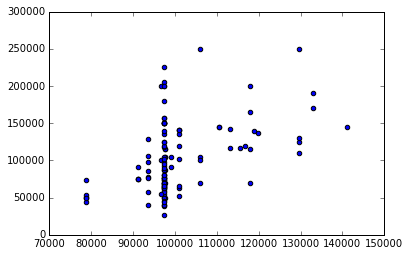

In [250]:
plt.scatter(gs.predict(X), y)

## Regression, but with TD-IDF'd X (plus location)

In [ ]:
X = listings.loc[:, ['titles', 'summaries']]
y = listings.above_median
X['alltext'] = X.titles + X.summaries
X.drop(['titles', 'summaries'], axis=1, inplace=True)
X_train.values.ravel()
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()
tvec.fit(X.values.ravel(), y)

In [ ]:
X = pd.DataFrame(tvec.transform(X.values.ravel()).todense(),
                   columns=tvec.get_feature_names())

In [ ]:
X['city'] = listings.city

In [ ]:
X.city = pd.DataFrame(LabelEncoder().fit_transform(X.city))

In [294]:
param_grid = {'n_estimators':[8,10,12,20],
              'max_features':['sqrt', 'log2', None],
              'min_samples_split':[2,4,6,8],
              'min_samples_leaf': [1,2,3,4]}

gs = GridSearchCV(rfr, param_grid, cv=cv).fit(X, listings.salary)
print gs.best_score_
print gs.best_params_

0.210141716051
{'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 10, 'min_samples_leaf': 1}


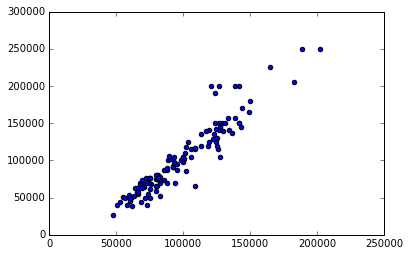

In [295]:
plt.scatter(gs.predict(X), listings.salary)

In [319]:
X = listings.loc[:, ['titles', 'summaries']]
y = listings.above_median
X['alltext'] = X.titles + X.summaries
X.drop(['titles', 'summaries'], axis=1, inplace=True)
X_train.values.ravel()
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()
tvec.fit(X.values.ravel(), y)
X = pd.DataFrame(tvec.transform(X.values.ravel()).todense(),
                   columns=tvec.get_feature_names())